In [1]:
# Load libraries

# # Plotting utils 
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import matplotlib.ticker as ticker 
import matplotlib.patches as patches
import matplotlib as matplotlib
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import make_axes_locatable

import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.util
from cartopy.util import add_cyclic_point

# import regionmask

import seaborn as sns

# Analysis
# import os
import time
import numpy as np 
import xarray as xr
import datetime
from   datetime import date, timedelta
import pandas as pd 
import pickle
import scipy.stats as stats

# Import Ngl with pyn_env active 
# import Ngl

import metpy.calc as mpc
from metpy.units import units
from metpy.plots import Hodograph, SkewT

import warnings
warnings.filterwarnings('ignore')



## Read in daily data

In [2]:
saveDir = '/glade/work/mdfowler/gust_cam7/output/'

## Read in U and V 
gustFileU = 'F2010climo.f09_f09_mg17.TestGustGlobal.001.cam.h1.02-11_UselectLevs.nc'
ctrlFileU = 'F2010climo.f09_f09_mg17.TestGustGlobal_Control.001.cam.h1.02-11_UselectLevs.nc'

gustFileV = 'F2010climo.f09_f09_mg17.TestGustGlobal.001.cam.h1.02-11_VselectLevs.nc'
ctrlFileV = 'F2010climo.f09_f09_mg17.TestGustGlobal_Control.001.cam.h1.02-11_VselectLevs.nc'

gustFile1d = 'F2010climo.f09_f09_mg17.TestGustGlobal.001.cam.h1.02-11_1dVars.nc'
ctrlFile1d = 'F2010climo.f09_f09_mg17.TestGustGlobal_Control.001.cam.h1.02-11_1dVars.nc'

gustFilePS = 'F2010climo.f09_f09_mg17.TestGustGlobal.001.cam.h1.02-11_PS.nc'
ctrlFilePS = 'F2010climo.f09_f09_mg17.TestGustGlobal_Control.001.cam.h1.02-11_PS.nc'

# Open datasets 
gustU = xr.open_dataset(saveDir+gustFileU, decode_times=True) 
ctrlU = xr.open_dataset(saveDir+ctrlFileU, decode_times=True) 

gustV = xr.open_dataset(saveDir+gustFileV, decode_times=True) 
ctrlV = xr.open_dataset(saveDir+ctrlFileV, decode_times=True) 

gust1d = xr.open_dataset(saveDir+gustFile1d, decode_times=True)
ctrl1d = xr.open_dataset(saveDir+ctrlFile1d, decode_times=True)

gustPS = xr.open_dataset(saveDir+gustFilePS, decode_times=True)
ctrlPS = xr.open_dataset(saveDir+ctrlFilePS, decode_times=True) 


## Get JJA and DJF means

In [3]:
iJJA = np.where( (gustU['time.month']>=6)  & (gustU['time.month']<=8) )[0]
iDJF = np.where( (gustU['time.month']==12) | (gustU['time.month']<=2) )[0]

gustU_JJA = gustU.isel(time=iJJA)
gustV_JJA = gustV.isel(time=iJJA)
gustU_DJF = gustU.isel(time=iDJF)
gustV_DJF = gustV.isel(time=iDJF)

ctrlU_JJA = ctrlU.isel(time=iJJA)
ctrlV_JJA = ctrlV.isel(time=iJJA)
ctrlU_DJF = ctrlU.isel(time=iDJF)
ctrlV_DJF = ctrlV.isel(time=iDJF)


In [4]:
gustPS_JJA = gustPS.isel(time=iJJA)
gustPS_DJF = gustPS.isel(time=iDJF)

ctrlPS_JJA = ctrlPS.isel(time=iJJA)
ctrlPS_DJF = ctrlPS.isel(time=iDJF) 

## Streamline plots

In [5]:
# Mean of gust winds (directional) 
gustU_meanJJA = gustU_JJA.mean(dim='time')
gustV_meanJJA = gustV_JJA.mean(dim='time')

gustU_meanDJF = gustU_DJF.mean(dim='time')
gustV_meanDJF = gustV_DJF.mean(dim='time')

# Mean of ctrl winds (directional)
ctrlU_meanJJA = ctrlU_JJA.mean(dim='time')
ctrlV_meanJJA = ctrlV_JJA.mean(dim='time')

ctrlU_meanDJF = ctrlU_DJF.mean(dim='time')
ctrlV_meanDJF = ctrlV_DJF.mean(dim='time')

# Mean wind speed overall
gustSpeed_meanJJA = np.nanmean(np.sqrt(gustU_JJA.U.values**2 + gustV_JJA.V.values**2), axis=0)
gustSpeed_meanDJF = np.nanmean(np.sqrt(gustU_DJF.U.values**2 + gustV_DJF.V.values**2), axis=0)

ctrlSpeed_meanJJA = np.nanmean(np.sqrt(ctrlU_JJA.U.values**2 + ctrlV_JJA.V.values**2), axis=0)
ctrlSpeed_meanDJF = np.nanmean(np.sqrt(ctrlU_DJF.U.values**2 + ctrlV_DJF.V.values**2), axis=0)




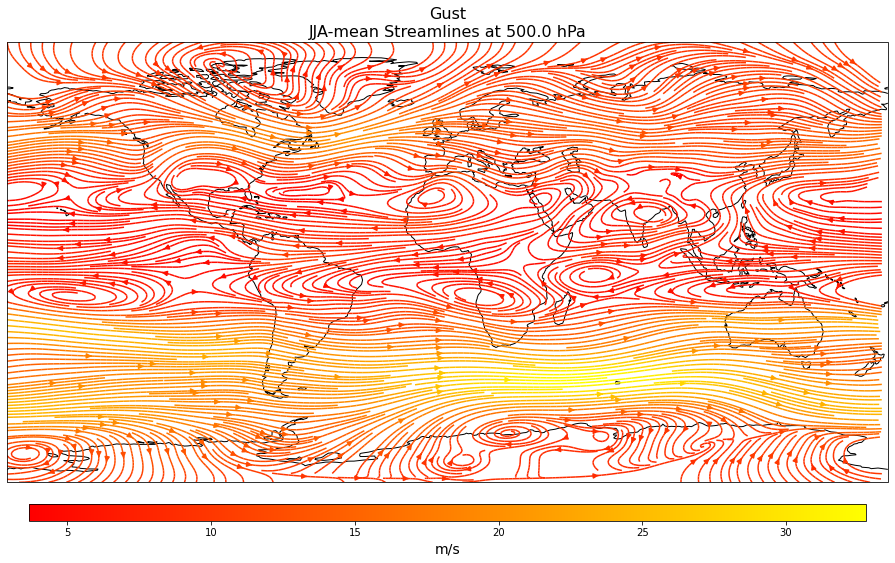

In [11]:
fig = plt.figure(figsize=(20, 10))
ax  = plt.axes(projection=ccrs.PlateCarree())

levSel = 1

# plot velocity field
uvel, lonu = add_cyclic_point(gustU_meanJJA.U, coord=gustU_meanJJA.lon)
vvel, lonv = add_cyclic_point(gustV_meanJJA.V, coord=gustV_meanJJA.lon)
spd,  lons = add_cyclic_point(gustSpeed_meanJJA, coord=gustV_meanJJA.lon)

lonu = np.where(lonu>=180.,lonu-360.,lonu)

strm=ax.streamplot(lonu, gustU.lat.values, 
                   uvel[levSel,:,:], vvel[levSel,:,:], 
                   density=5,
                   color=spd[levSel,:,:], 
                   cmap='autumn', 
                   transform=ccrs.PlateCarree())
cbar = fig.colorbar(strm.lines, orientation='horizontal',pad=0.04, aspect=50, shrink=0.75)
cbar.set_label(gustU['U'].units,fontsize=14)

ax.set_title('Gust\nJJA-mean Streamlines at '+str(gustU.lev.values[levSel])+' hPa', fontsize=16)
ax.coastlines()

# ax.set_extent([50, 180, -20, 55], crs=ccrs.PlateCarree())

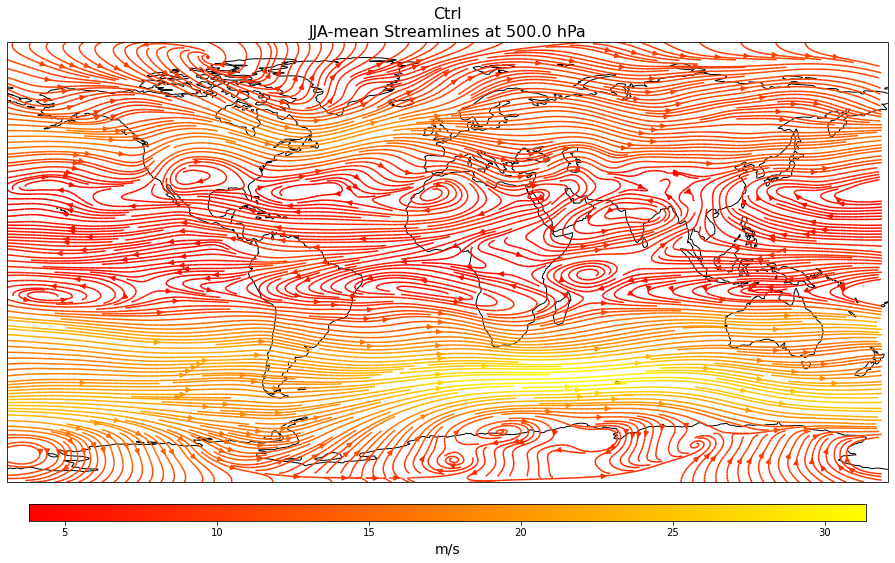

In [12]:
fig = plt.figure(figsize=(20, 10))
ax  = plt.axes(projection=ccrs.PlateCarree())

levSel = 1

# plot velocity field
uvel, lonu = add_cyclic_point(ctrlU_meanJJA.U,   coord=ctrlU_meanJJA.lon)
vvel, lonv = add_cyclic_point(ctrlV_meanJJA.V,   coord=ctrlV_meanJJA.lon)
spd,  lons = add_cyclic_point(ctrlSpeed_meanJJA, coord=ctrlV_meanJJA.lon)

lonu = np.where(lonu>=180.,lonu-360.,lonu)

strm=ax.streamplot(lonu, gustU.lat.values, 
                   uvel[levSel,:,:], vvel[levSel,:,:], 
                   density=5,
                   color=spd[levSel,:,:], 
                   cmap='autumn', 
                   transform=ccrs.PlateCarree())
cbar = fig.colorbar(strm.lines, orientation='horizontal',pad=0.04, aspect=50, shrink=0.75)
cbar.set_label(ctrlU['U'].units,fontsize=14)

ax.set_title('Ctrl\nJJA-mean Streamlines at '+str(ctrlU.lev.values[levSel])+' hPa', fontsize=16)
ax.coastlines()

# ax.set_extent([50, 180, -20, 55], crs=ccrs.PlateCarree())

In [14]:
## Mean of PS 
gustPS_meanJJA = gustPS_JJA.mean(dim='time')
gustPS_meanDJF = gustPS_DJF.mean(dim='time')

ctrlPS_meanJJA = ctrlPS_JJA.mean(dim='time')
ctrlPS_meanDJF = ctrlPS_DJF.mean(dim='time')


In [18]:
from scipy.ndimage import gaussian_filter

In [27]:
## What if we smooth the mean pressures...?

# Grab MSLP and smooth, use MetPy Units module for conversion
EMSLgust = gustPS_meanJJA.PS.values * units.Pa
mslpGust = gaussian_filter(EMSLgust, sigma=3.0)

EMSLctrl = ctrlPS_meanJJA.PS.values * units.Pa
mslpCtrl = gaussian_filter(EMSLctrl, sigma=3.0)


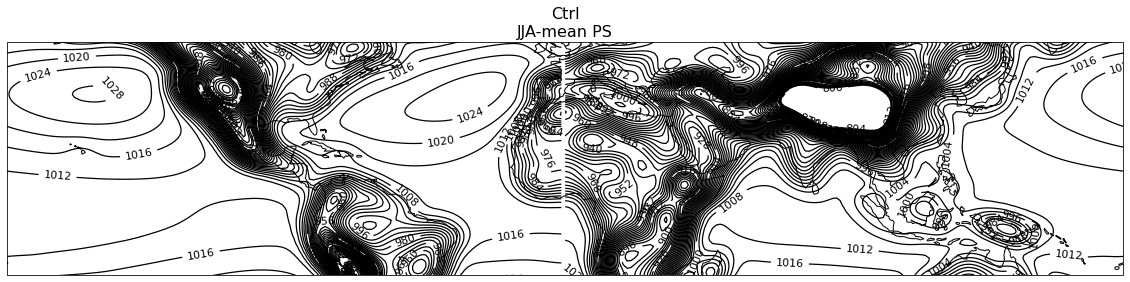

In [36]:
fig = plt.figure(figsize=(20, 10))
axs  = plt.axes(projection=ccrs.PlateCarree())

## Plot raw values
# cMax  = np.nanmax([np.nanpercentile(gustPS_meanJJA.PS.values/100.0, 99), np.nanpercentile(ctrlPS_meanJJA.PS.values/100.0, 99)])
# cMin  = np.nanmax([np.nanpercentile(gustPS_meanJJA.PS.values/100.0, 10), np.nanpercentile(ctrlPS_meanJJA.PS.values/100.0, 10)])
# cStep = (cMax - cMin)/100.0
clevmslp = np.arange(800., 1120., 4)
cs2 = axs.contour(gustPS.lon.values, gustPS.lat.values,
                            mslpCtrl/100.0,
                            clevmslp, colors='k', linewidths=1.25,
                            linestyles='solid', transform=ccrs.PlateCarree())

kw_clabels = {'fontsize': 11, 'inline': True, 'inline_spacing': 5, 'fmt': '%i',
              'rightside_up': True, 'use_clabeltext': True}
plt.clabel(cs2, **kw_clabels)

# # Add colorbar
# cbar = fig.colorbar(contour_plot, orientation='horizontal',pad=0.04, aspect=50, shrink=0.75)
# cbar.set_label(gustPS['PS'].units,fontsize=11)

axs.set_title('Ctrl\nJJA-mean PS', fontsize=16)
axs.coastlines()

axs.set_extent([40, 230, -20, 55], crs=ccrs.PlateCarree())   


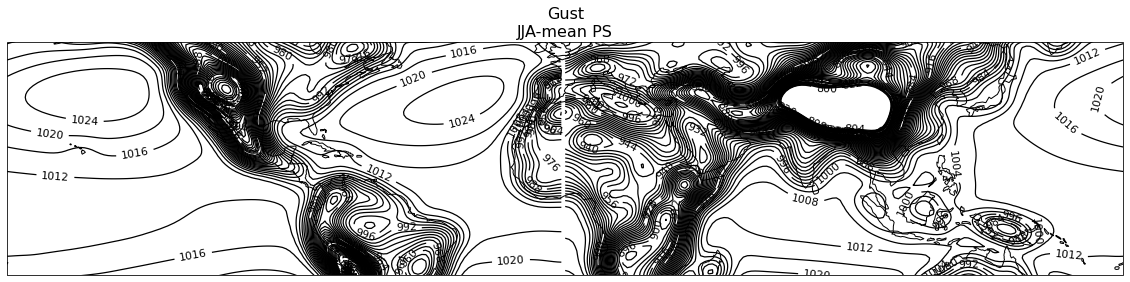

In [35]:
fig = plt.figure(figsize=(20, 10))
axs  = plt.axes(projection=ccrs.PlateCarree())

## Plot raw values
# cMax  = np.nanmax([np.nanpercentile(gustPS_meanJJA.PS.values/100.0, 99), np.nanpercentile(ctrlPS_meanJJA.PS.values/100.0, 99)])
# cMin  = np.nanmax([np.nanpercentile(gustPS_meanJJA.PS.values/100.0, 10), np.nanpercentile(ctrlPS_meanJJA.PS.values/100.0, 10)])
# cStep = (cMax - cMin)/100.0
clevmslp = np.arange(800., 1120., 4)
cs2 = axs.contour(gustPS.lon.values, gustPS.lat.values,
                            mslpGust/100.0,
                            clevmslp, colors='k', linewidths=1.25,
                            linestyles='solid', transform=ccrs.PlateCarree())

kw_clabels = {'fontsize': 11, 'inline': True, 'inline_spacing': 5, 'fmt': '%i',
              'rightside_up': True, 'use_clabeltext': True}
plt.clabel(cs2, **kw_clabels)

# # Add colorbar
# cbar = fig.colorbar(contour_plot, orientation='horizontal',pad=0.04, aspect=50, shrink=0.75)
# cbar.set_label(gustPS['PS'].units,fontsize=11)

axs.set_title('Gust\nJJA-mean PS', fontsize=16)
axs.coastlines()

axs.set_extent([40, 230, -20, 55], crs=ccrs.PlateCarree())   


In [37]:
## A few observational files would be helpful too... 
obsDir = '/glade/p/cesm/amwg/amwg_diagnostics/obs_data/'

erai_jja = xr.open_dataset(obsDir+'ERAI_JJA_climo.nc', decode_times=False) 


In [43]:
erai_jja_PS = erai_jja.PS.values ## Already in mb

EMSLobs = np.squeeze(erai_jja_PS) * units.mb
mslpObs = gaussian_filter(EMSLobs, sigma=3.0)

In [44]:
np.shape(erai_jja_PS)

(1, 121, 240)

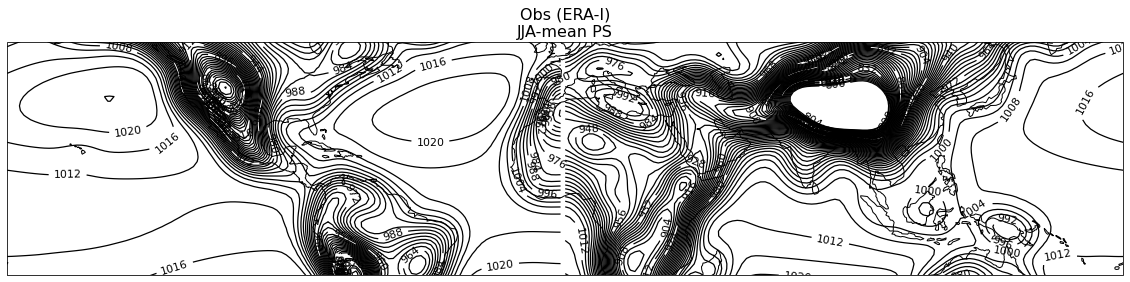

In [46]:
fig = plt.figure(figsize=(20, 10))
axs  = plt.axes(projection=ccrs.PlateCarree())

## Plot raw values
# cMax  = np.nanmax([np.nanpercentile(gustPS_meanJJA.PS.values/100.0, 99), np.nanpercentile(ctrlPS_meanJJA.PS.values/100.0, 99)])
# cMin  = np.nanmax([np.nanpercentile(gustPS_meanJJA.PS.values/100.0, 10), np.nanpercentile(ctrlPS_meanJJA.PS.values/100.0, 10)])
# cStep = (cMax - cMin)/100.0
clevmslp = np.arange(800., 1120., 4)
cs2 = axs.contour(erai_jja.lon.values, erai_jja.lat.values,
                            mslpObs,
                            clevmslp, colors='k', linewidths=1.25,
                            linestyles='solid', transform=ccrs.PlateCarree())

kw_clabels = {'fontsize': 11, 'inline': True, 'inline_spacing': 5, 'fmt': '%i',
              'rightside_up': True, 'use_clabeltext': True}
plt.clabel(cs2, **kw_clabels)

# # Add colorbar
# cbar = fig.colorbar(contour_plot, orientation='horizontal',pad=0.04, aspect=50, shrink=0.75)
# cbar.set_label(gustPS['PS'].units,fontsize=11)

axs.set_title('Obs (ERA-I)\nJJA-mean PS', fontsize=16)
axs.coastlines()

axs.set_extent([40, 230, -20, 55], crs=ccrs.PlateCarree())   
